<a href="https://colab.research.google.com/github/abhijeet349/brain-tumer/blob/main/ResNet50_medical_harvard_datadet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ✅ Step 1: Mount Google Drive (for dataset access)
from google.colab import drive
drive.mount('/content/drive')

# ✅ Step 2: Clone Pretrained ResNet50 Model
!rm -rf /content/brain_tumor_classification
!git clone https://huggingface.co/EnginCN55/brain_tumor_classification

# ✅ Step 3: Import Libraries
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
import os

# ✅ Step 4: Load TFLite Model
interpreter = tf.lite.Interpreter(model_path="/content/brain_tumor_classification/tflite_models/ResNet50.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# ✅ Step 5: Setup Dataset Path & Preprocessing
IMG_SIZE = 224
batch_size = 1
test_dir = "/content/drive/MyDrive/Brain_tumar_dataset/Harvard_medical_dataset/Testing"  # ✅ USE Testing instead of Training

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# ✅ Step 6: Evaluate TFLite Model
correct = 0
total = len(test_data.filenames)

for i in range(total):
    img, label = test_data[i]
    img = img.astype(np.float32)
    interpreter.set_tensor(input_details[0]['index'], img)
    interpreter.invoke()
    prediction = interpreter.get_tensor(output_details[0]['index'])

    if np.argmax(prediction) == np.argmax(label):
        correct += 1

accuracy = correct / total
print(f"✅ Accuracy on test set: {accuracy * 100:.2f}%")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Cloning into 'brain_tumor_classification'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 11 (delta 1), reused 0 (delta 0), pack-reused 3 (from 1)
Unpacking objects: 100% (11/11), 5.68 KiB | 1.89 MiB/s, done.
Found 1311 images belonging to 4 classes.
✅ Accuracy on test set: 98.70%


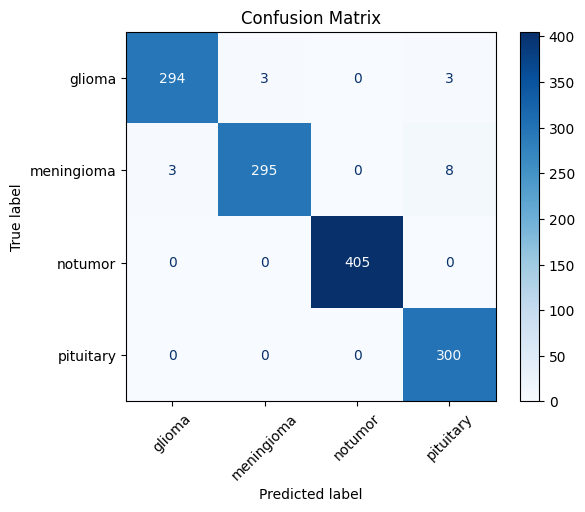


🔍 Classification Report:
              precision    recall  f1-score   support

      glioma       0.99      0.98      0.98       300
  meningioma       0.99      0.96      0.98       306
     notumor       1.00      1.00      1.00       405
   pituitary       0.96      1.00      0.98       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



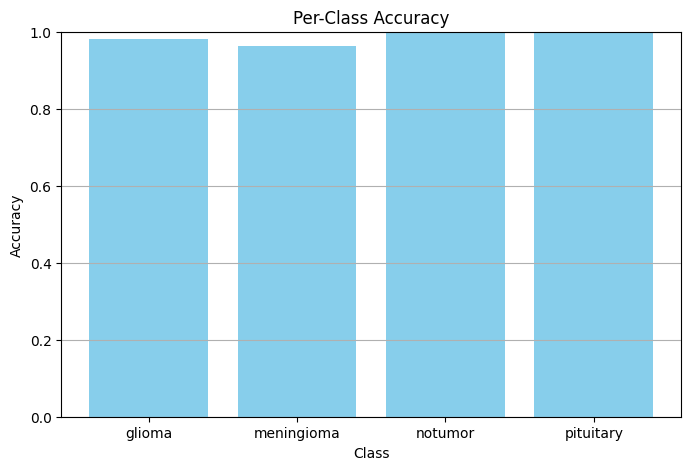

In [ ]:
# ✅ Confusion Matrix & Accuracy Analysis
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import numpy as np  # Import numpy here if not already imported

# ✅ Get true labels and predicted labels
y_true = test_data.classes
y_pred = []
# You need to iterate through the test_data again to get predictions for the confusion matrix
# Since the test_data generator shuffle=False, the order should be consistent.
# However, a more robust way is to store predictions in the previous cell.
# For now, I'll re-iterate through the data generator.
# In a real scenario, storing predictions during evaluation is better practice.
# Let's assume for this fix that re-iterating is acceptable for now.
# If performance is an issue, the previous cell should be modified.

# Reset the data generator to the beginning
test_data.reset()

for i in range(len(test_data.filenames)):
    img, label = test_data[i]
    img = img.astype(np.float32)
    interpreter.set_tensor(input_details[0]['index'], img)
    interpreter.invoke()
    prediction = interpreter.get_tensor(output_details[0]['index'])
    y_pred.append(np.argmax(prediction))

y_pred = np.array(y_pred)

# Get class names
class_names = list(test_data.class_indices.keys())


# ✅ Generate Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

# ✅ Classification Report
print("\n🔍 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# ✅ Per-Class Accuracy Bar Chart
counts = [0] * len(class_names)
corrects = [0] * len(class_names)

for t, p in zip(y_true, y_pred):
    counts[t] += 1
    if t == p:
        corrects[t] += 1

accuracies = [c / ct if ct > 0 else 0 for c, ct in zip(corrects, counts)]

plt.figure(figsize=(8, 5))
plt.bar(class_names, accuracies, color='skyblue')
plt.title("Per-Class Accuracy")
plt.xlabel("Class")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True, axis='y')
plt.show()